# Predicting Airbnb nightly price from property and host data

Authors: Tomas Beuzen, Florencia D'Andrea, Mds Octocat and Tiffany Timbers

In [1]:
options(repr.matrix.max.rows = 6)
set.seed(2022)
library(cowplot)
library(tidymodels)
library(tidyverse)
library(vroom)
source("../R/summarize_col.R")

Registered S3 method overwritten by 'tune':
  method                   from   
  required_pkgs.model_spec parsnip

── Attaching packages ────────────────────────────────────── tidymodels 0.1.4 ──

✔ broom        0.7.10     ✔ recipes      0.1.17
✔ dials        0.0.10     ✔ rsample      0.1.0 
✔ dplyr        1.0.7      ✔ tibble       3.1.6 
✔ ggplot2      3.3.5      ✔ tidyr        1.1.4 
✔ infer        1.0.0      ✔ tune         0.1.6 
✔ modeldata    0.1.1      ✔ workflows    0.2.4 
✔ parsnip      0.1.7      ✔ workflowsets 0.1.0 
✔ purrr        0.3.4      ✔ yardstick    0.0.8 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ readr   2.0.1     ✔ forcats 0.5.1
✔ 

## Summary

Here we attempt to build a regression model, using the k-nearest neighbors algorithm, which uses characteristics of an Airbnb property and host (price, bedrooms, host response rate, etc.) to predict the nightly price of the property. This model could help prospective and exisiting hosts determine how to price their new or existing property. Our current model has a prediction error, as measured by root mean square prediction error (RMSPE), of about \\$70. This model, is useful, however it could use some improvement given that the nightly prices in our data set range from \\$0-\\$1000, and the median nightly price is \\$119.

The data we used to build our model contains all the active Airbnb listings for Vancouver, Canada from April 2021. The data was collected from http://insideairbnb.com/.

## Introduction

[AirBnB](https://www.airbnb.ca/) is a popular short-term rental web platform where individuals can list their couch, room, suite, or entire home for rent for various periods of time. When a new host wants to list a rental, how much should they rent it for? If the host asks too little, then they can potentially lose out on profits, however if they ask too much, their rental might get booked less often, or not at all. Thus, our question is can we use characteristics of a rental to predict the price a new rental unit should be listed at? 

In an attempt to answer this question we used a K-nearest neighbours regression model and data from active Airbnb listings for Vancouver, Canada from April 2021 to build a regression model. We found that our regression model had a prediction error of  about \\$70. This model, is useful, however it could use some improvement given that the nightly prices in our data set range from \\$0-\\$1000, and the median nightly price is \\$119.


## Methods

### Data

The data set used in this project is 74 characteristics from active AirBnB short-term rental units from Vancouver, Canada, 
as well as the property's nightly price collected during April 2021 from http://insideairbnb.com/. 
Using domain expertise, we chose to focus on 10 predictor variables (Table 1). 


Table 1. Predictor variables used for analysis, chosen for their utility by domain expertise.

| Predictor variable | Description |
|--------------------|-------------|
| `host_response_rate` | Percentage of new inquiries and reservation requests the host responded to (by either accepting/pre-approving or declining) within 24 hours |
| `host_acceptance_rate` |  Percentage of reservation requests the host accepts |
| `latitude` | Measure of location north or south of the Equator |
| `longitude` |Measure of location east or west of the prime meridian at Greenwich, London, England |
| `bedrooms` | Number of bedrooms in the rental unit |
| `beds` | Number of beds in the rental unit |
| `accommodates` | Maximum number of guests the rental unit can accommodate |
| `minimum_nights` | Minimum number of nights a guests must stay to be able to reserve the rental unit |
| `review_scores_rating` | Review score of the property |
| `number_of_reviews` | Number of reviews |


Data cleaning was performed to remove properties with no reviews (as some of our predictor variables were constructed from reviews), remove data with missing values, as remove special characters (percent symbols and currency symbols) from predictor variables that should have been numeric, and convert that data to numeric types.

### Analysis
Data was partitioned into training and test sets (80% and 20%, respectively).
The relationship between price and all predictor variables listed in table 1 was first visualized to grossly assess their utility for predictive modelling. Predictor variables that visually showed no evidence of having a relationship with price were omitted from modelling. The k-nearest neighbors (k-nn) algorithm was used to build a regression model to predict the nightly AirBnB rental unit price. All data was scaled before fitting our model so that all predictor variables were equally weighted. The hyperparameter K was chosen using 10-fold cross validation with root mean squared predictive error (RMSPE) as the regression model metric. The R programming languages (R Core Team 2019) and the following R packages were used to perform the analysis: tidymodels (Kuhn et al., 2020) and tidyverse (Wickham 2017). Jupyter (Kluver et al., 2016) was used for rendering the reproducible report. The code used to perform the analysis is contained within this report.

## Results & Discussion

In [2]:
url <- "http://data.insideairbnb.com/canada/bc/vancouver/2021-04-12/data/listings.csv.gz"
use_cols <- c("host_response_rate", "host_acceptance_rate", "latitude", 
              "longitude", "bedrooms", "beds", "minimum_nights", "accommodates", 
              "price", "review_scores_rating", "number_of_reviews")
listings <- vroom(url, col_select = use_cols)
write_csv(listings, "../data/raw/listings.csv")

listings <- listings |> 
  filter(number_of_reviews >= 1) |> 
  drop_na() |> 
  mutate(host_response_rate = str_remove(host_response_rate, "[%]") |> as.numeric(),
         host_acceptance_rate = str_remove(host_acceptance_rate, "[%]") |> as.numeric(),
         price = str_remove(price, "[$]") |> as.numeric()) 

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(use_cols)` instead of `use_cols` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.

Rows: 4299 Columns: 11

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): host_response_rate, host_acceptance_rate, price
dbl (8): latitude, longitude, accommodates, bedrooms, beds, minimum_nights, ...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


We partitioned the data into training and test sets, choosing 80% of the data to go in the training set and 20% of the data to go in the test set. To check that we had enough data representation in the test set, we computed the median, mean and standard deviation for both data partitions to ensure they were similar.

In [3]:
listings_split <- initial_split(listings, prop = 0.8, strata = price)
listings_train <- training(listings_split)
listings_test <- testing(listings_split)

write_csv(listings_train, "../data/processed/listings_train.csv")
write_csv(listings_test, "../data/processed/listings_test.csv")

listings_train_summary <- summarize_col(listings_train, price)

listings_test_summary <- summarize_col(listings_test, price)

listings_tt_summary <- bind_rows(listings_train_summary, listings_test_summary) |>
    mutate(partition = c("Train", "Test"),
           fraction = c(0.8, 0.2))|> 
    relocate(partition, fraction)

**Table 1.** Summary statistics for response variable price for each data partition.

In [4]:
listings_tt_summary

partition,fraction,median,mean,standard_deviation
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Train,0.8,119,148.1376,110.6768
Test,0.2,119,147.4167,109.2699


We wanted to determine which of our predictor variables were important for predicting the response variable price. To this end, we created scatter plots of each of the features with the response price and fit a regression line.

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 726 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 726 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 622 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 622 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 8 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 8 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 8 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 8 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 8 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 8 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

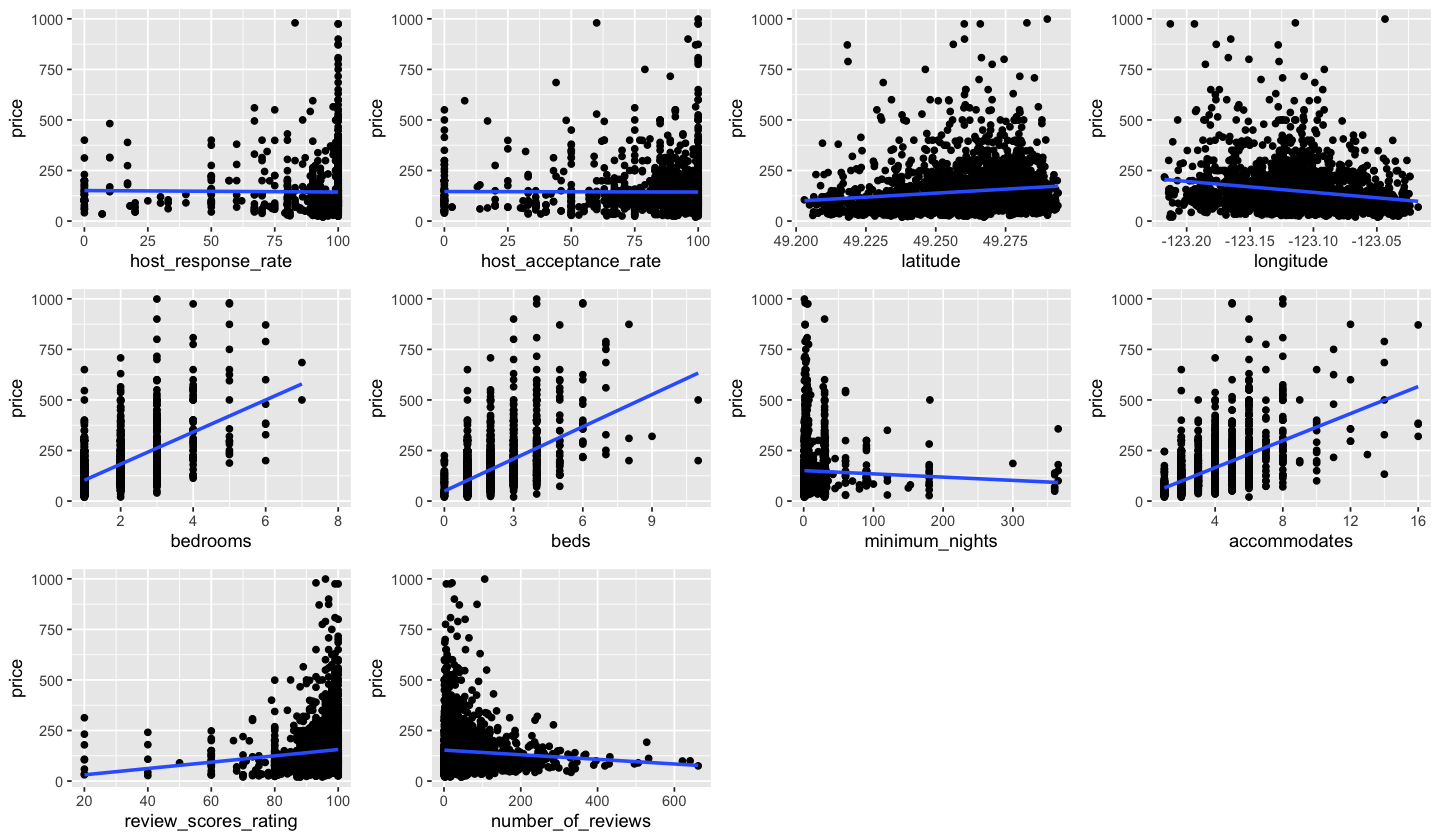

In [5]:
scatter_host_response_rate <- ggplot(listings_train, aes(x = host_response_rate, y = price)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

scatter_host_acceptance_rate <- ggplot(listings_train, aes(x = host_acceptance_rate, y = price)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

scatter_latitude <- ggplot(listings_train, aes(x = latitude, y = price)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

scatter_longitude <- ggplot(listings_train, aes(x = longitude, y = price)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

scatter_bedrooms <- ggplot(listings_train, aes(x = bedrooms, y = price)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

scatter_beds <- ggplot(listings_train, aes(x = beds, y = price)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

scatter_minimum_nights <- ggplot(listings_train, aes(x = minimum_nights, y = price)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

scatter_accommodates <- ggplot(listings_train, aes(x = accommodates, y = price)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

scatter_review_scores_rating <- ggplot(listings_train, aes(x = review_scores_rating, y = price)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)

scatter_number_of_reviews <- ggplot(listings_train, aes(x = number_of_reviews, y = price)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE)


options(repr.plot.width=12)
plot_grid(scatter_host_response_rate,
         scatter_host_acceptance_rate,
         scatter_latitude,
         scatter_longitude,
         scatter_bedrooms,
         scatter_beds,
         scatter_minimum_nights,
         scatter_accommodates,
         scatter_review_scores_rating,
         scatter_number_of_reviews)

**Figure. 1.** Predictor variables versus response variable price, with a least squares regression line overlaid.

The features `host_response_rate`, `host_acceptance_rate` did not seem to be strongly correlated with the target, `price` based on the scatter and line plots. Thus we chose to drop these in our subsequent modelling.

We used K-nearest neighbors regression to predict Airbnb nightly prices from our predictor variables. To find the best value of the parameter k (number of nearest neighbours), we performed 10-fold cross validation using RMSPE as our metric of model prediction performance. Given that our input features were on different scales (e.g., latitude is in degrees and number of bedrooms is an integer) we scaled our data before fitting our model so that all predictor variables were equally weighted. We observed that the optimal K was 34 when using RMSPE as the model metric (Figure 2), thus we used this to tune our final model.

In [6]:
listings_recipe <- recipe(price ~ latitude + 
                          longitude + 
                          bedrooms + 
                          beds + 
                          minimum_nights + 
                          accommodates + 
                          review_scores_rating + 
                          number_of_reviews, 
                          data = listings_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

listings_spec <- nearest_neighbor(weight_func = "rectangular", 
                              neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

listings_vfold <- vfold_cv(listings_train, v = 10, strata = price)

gridvals <- tibble(neighbors = seq(from = 1, to = 200, by = 3))

listings_tuning <- workflow() |>
  add_recipe(listings_recipe) |>
  add_model(listings_spec) |>
  tune_grid(resamples = listings_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

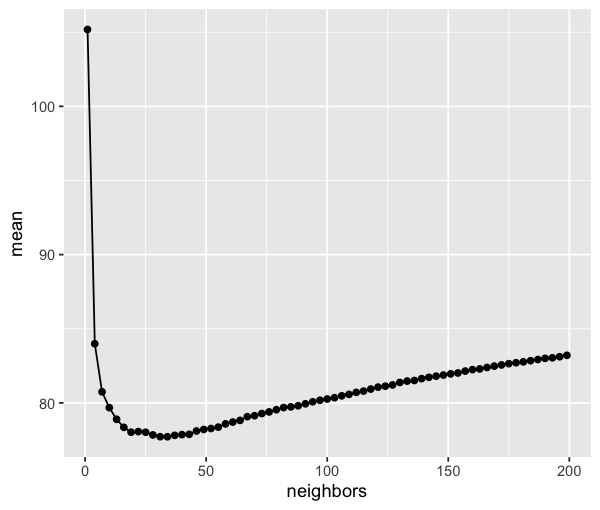

In [7]:
options(repr.plot.width = 5, repr.plot.height = 4.25)
ggplot(listings_tuning, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line()

kmin <- listings_tuning |> 
    arrange(mean) |> 
    slice(1)|> 
    pull(neighbors)

**Figure 2.** Number of nearest neighbours versus mean cross-validated RMSPE.

In [8]:
listings_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
  set_engine("kknn") |>
  set_mode("regression")

listings_fit <- workflow() |>
  add_recipe(listings_recipe) |>
  add_model(listings_spec) |>
  fit(data = listings_train)

listings_summary <- listings_fit |>
  predict(listings_test) |>
  bind_cols(listings_test) |>
  metrics(truth = price, estimate = .pred) |>
  filter(.metric == 'rmse')

listings_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,74.07366


**Table 2.** Prediction error on the test data with K = 34.

We observed that the test performance was similar to the cross-validation performance. Our results indicated that our model has RPMPE of about \\$70 per night which is useful. However it could use some improvement given that the nightly prices in our data set range from \\$0-\\$1000, and the median nightly price is \\$119. At this point, our model can provide Airbnb hosts with an estimate of how they should price their property, but it could be improved by collecting more data, or doing more intensive feature exploration and engineering. 

# References

Kluyver, Thomas et al. (2016). *Jupyter Notebooks-a publishing format for
reproducible computational workflows.* Vol. 2016.

Kuhn et al., (2020). *Tidymodels: a collection of packages for modeling and machine learning using tidyverse principles.* https://www.tidymodels.org

R Core Team. 2019. R: A Language and Environment for Statistical Computing. Vienna, Austria: R Foundation for Statistical Computing. https://www.R-project.org/.

Wickham, Hadley. 2017. Tidyverse: Easily Install and Load the ’Tidyverse’. https://CRAN.R-project.org/package=tidyverse.